# HetRec 2011
---
The 2nd International Workshop on Information Heterogeneity and Fusion in Recommender Systems (HetRec 2011, http://ir.ii.uam.es/hetrec2011) has released datasets from Delicious, Last.fm Web 2.0, MovieLens, IMDb, and Rotten Tomatoes. These datasets contain social networking, tagging, and resource consuming (Web page bookmarking and music artist listening) information from sets of around 2,000 users.

The datasets were generated by the Information Retrieval Group at Universidad Autónoma de Madrid (http://ir.ii.uam.es). Before using these datasets, please review the README files for the usage license and other details.

---

In [1]:
import numpy as np
import pandas as pd

import csv

from tqdm.notebook import tqdm

from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist, jaccard

from sklearn.preprocessing import Normalizer

import torch
import torch.nn.functional as F
from torch.autograd import Variable
from torch import nn

# Data loding
---

In [2]:
def dat_to_csv(dat_file, has_header=True, delimiter=',', save=False):
    with open(dat_file, 'r', encoding='cp437') as f:
        lines = f.read().split('\n')[:-1]
    
    if has_header:
        columns = lines[0].split(delimiter)
        lines = lines[1:]
    else:
        columns = [f'Column {i}' for i in range(len(lines[0].split(delimiter)))]
    
    df = pd.DataFrame(np.array([l.split(delimiter) for l in lines]), columns=columns)
    if save:
        df.to_csv(dat_file.replace('.dat', '.csv'))
    
    return df

## Delicious Bookmarks

In [3]:
df_db_bookmarks = dat_to_csv('hetrec2011/hetrec2011-delicious-2k/bookmarks.dat', delimiter='\t')
df_db_tags = dat_to_csv('hetrec2011/hetrec2011-delicious-2k/tags.dat', delimiter='\t')
df_db_usertagged = dat_to_csv('hetrec2011/hetrec2011-delicious-2k/user_taggedbookmarks-timestamps.dat', delimiter='\t')

In [4]:
df_db_bookmarks = df_db_bookmarks[['id', 'title']]
df_db_bookmarks.head()

,id,title
0,1,IFLA - The official website of the Internation...
1,2,gcdp-e.pdf (application/pdf Object)
2,7,EdSelect
3,8,Cool Canada (Collections Canada)
4,9,Kidsreads.com


In [5]:
df_db_tags.head()

,id,value
0,1,collection_development
1,2,library
2,3,collection
3,4,development
4,5,lesson_plan


In [6]:
df_db_usertagged = df_db_usertagged[['userID', 'bookmarkID', 'tagID']]
df_db_usertagged.head()

,userID,bookmarkID,tagID
0,8,1,1
1,8,2,1
2,8,7,1
3,8,7,6
4,8,7,7


In [7]:
print(f'Bookmarks: {len(df_db_bookmarks)}')
print(f'Tags: {len(df_db_tags)}')
print(f'Bookmark user taggings: {len(df_db_usertagged)}')

Bookmarks: 69226
Tags: 53388
Bookmark user taggings: 437593


## Last.FM

In [8]:
df_lf_artists = dat_to_csv('hetrec2011/hetrec2011-lastfm-2k/artists.dat', delimiter='\t')
df_lf_tags = dat_to_csv('hetrec2011/hetrec2011-lastfm-2k/tags.dat', delimiter='\t')
df_lf_usertagged = dat_to_csv('hetrec2011/hetrec2011-lastfm-2k/user_taggedartists-timestamps.dat', delimiter='\t')

In [9]:
df_lf_artists = df_lf_artists[['id', 'name']]
df_lf_artists.head()

,id,name
0,1,MALICE MIZER
1,2,Diary of Dreams
2,3,Carpathian Forest
3,4,Moi dix Mois
4,5,Bella Morte


In [10]:
df_lf_tags.head()

,tagID,tagValue
0,1,metal
1,2,alternative metal
2,3,goth rock
3,4,black metal
4,5,death metal


In [11]:
df_lf_usertagged = df_lf_usertagged[['userID', 'artistID', 'tagID']]
df_lf_usertagged.head()

,userID,artistID,tagID
0,2,52,13
1,2,52,15
2,2,52,18
3,2,52,21
4,2,52,41


In [12]:
print(f'Artists: {len(df_lf_artists)}')
print(f'Tags: {len(df_lf_tags)}')
print(f'Artist user taggings: {len(df_lf_usertagged)}')

Artists: 17632
Tags: 11946
Artist user taggings: 186479


## MovieLens + IMDb/Rotten Tomatoes

In [13]:
df_ml_movies = dat_to_csv('hetrec2011/hetrec2011-movielens-2k-v2/movies.dat', delimiter='\t')
df_ml_tags = dat_to_csv('hetrec2011/hetrec2011-movielens-2k-v2/tags.dat', delimiter='\t')
df_ml_moviegenres = dat_to_csv('hetrec2011/hetrec2011-movielens-2k-v2/movie_genres.dat', delimiter='\t')
df_ml_usertagged = dat_to_csv('hetrec2011/hetrec2011-movielens-2k-v2/user_taggedmovies-timestamps.dat', delimiter='\t')
df_ml_userrated = dat_to_csv('hetrec2011/hetrec2011-movielens-2k-v2/user_ratedmovies-timestamps.dat', delimiter='\t')

In [14]:
df_ml_movies = df_ml_movies[['id', 'title']]
df_ml_movies.head()

,id,title
0,1,Toy story
1,2,Jumanji
2,3,Grumpy Old Men
3,4,Waiting to Exhale
4,5,Father of the Bride Part II


In [15]:
df_ml_tags.head()

,id,value
0,1,earth
1,2,police
2,3,boxing
3,4,painter
4,5,whale


In [16]:
df_ml_moviegenres.head()

,movieID,genre
0,1,Adventure
1,1,Animation
2,1,Children
3,1,Comedy
4,1,Fantasy


In [17]:
df_ml_usertagged = df_ml_usertagged[['userID', 'movieID', 'tagID']]
df_ml_usertagged.head()

,userID,movieID,tagID
0,75,353,5290
1,78,4223,5264
2,127,1343,1544
3,127,1343,12330
4,127,2080,1451


In [18]:
df_ml_userrated = df_ml_userrated[['userID', 'movieID', 'rating']]
df_ml_userrated.head()

,userID,movieID,rating
0,75,3,1
1,75,32,4.5
2,75,110,4
3,75,160,2
4,75,163,4


In [19]:
print(f'Movies: {len(df_ml_movies)}')
print(f'Tags: {len(df_ml_tags)}')
print(f'Genres: {len(df_ml_moviegenres)}')
print(f'Artist user taggings: {len(df_ml_usertagged)}')
print(f'Artist user ratings: {len(df_ml_userrated)}')

Movies: 10197
Tags: 13222
Genres: 20809
Artist user taggings: 47957
Artist user ratings: 855598


# Data analysis
---

## Tagclouds

In [20]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [21]:
def get_tags(df_usertagged, df_tags, tagcols=('tagID', 'id', 'value'), freq_thr=100, shuffle=True):
    df_common = df_usertagged.merge(df_tags, left_on=tagcols[0], right_on=tagcols[1])
    
    tags_list = np.array([f"#{t.replace(' ', '_')}" for t in df_common[tagcols[2]]])
    
    # reduce to tags above freq_thr value
    tags_list = most_frequent_above(tags_list, freq_thr)
    
    if shuffle:
        np.random.shuffle(tags_list)
    
    return tags_list

def most_frequent_above(tags, freq_thr=100):
    freq_dict = dict()
    for tag in tags:
        if tag not in freq_dict:
            freq_dict[tag] = 0
        freq_dict[tag] += 1
    
    top_tags = list(filter(lambda x: x[1] >= freq_thr, freq_dict.items()))
    return [tt[0] for tt in top_tags]

def generate_wordcloud(text, title, max_words=10000, save_file=None):
    wc = WordCloud(max_words=10000, height=400, width=800, stopwords=set(STOPWORDS), margin=10, random_state=1).generate(text)
    plt.figure(figsize=(14, 20))
    plt.title(title)
    plt.axis("off")
    plt.imshow(wc, interpolation='bilinear')
    if save_file:
        plt.savefig(save_file)
    plt.show()

In [22]:
db_tags = get_tags(df_db_usertagged, df_db_tags)
lf_tags = get_tags(df_lf_usertagged, df_lf_tags, tagcols=('tagID', 'tagID', 'tagValue'))
ml_tags = get_tags(df_ml_usertagged, df_ml_tags)

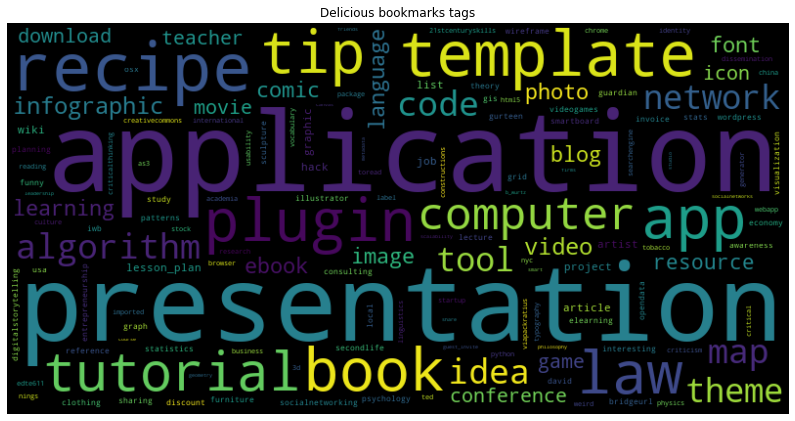

In [23]:
generate_wordcloud(' '.join(db_tags), title='Delicious bookmarks tags',
                   max_words=100000, save_file='hetrec2011/db_tags.png')

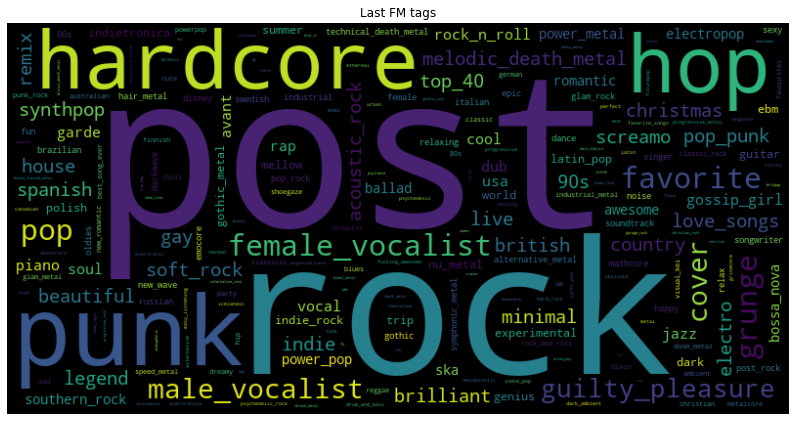

In [24]:
generate_wordcloud(' '.join(lf_tags), title='Last FM tags',
                   max_words=50000, save_file='hetrec2011/lf_tags.png')

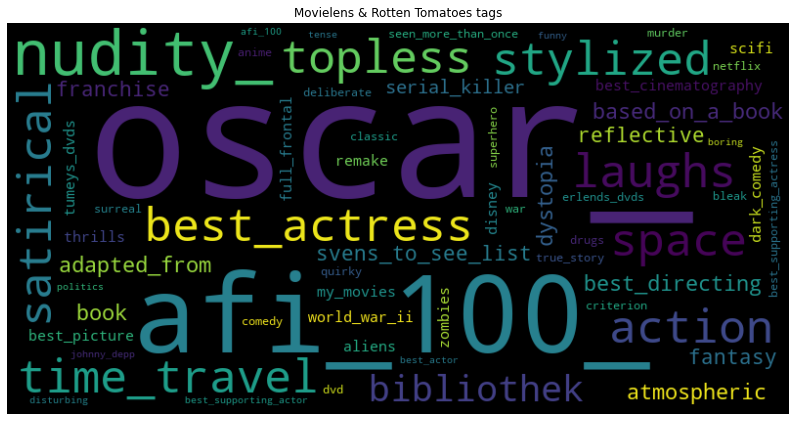

In [25]:
generate_wordcloud(' '.join(ml_tags), title='Movielens & Rotten Tomatoes tags',
                   max_words=25000, save_file='hetrec2011/ml_tags.png')

In [26]:
n_db_tags = np.size(np.unique(db_tags))
n_lf_tags = np.size(np.unique(lf_tags))
n_ml_tags = np.size(np.unique(ml_tags))

## Common tags

In [27]:
def common_tags(s1, s2):
    return np.intersect1d(np.unique(s1), np.unique(s2))

In [28]:
ct = common_tags(db_tags, lf_tags)
print(f'Common tags in bookmarks and music:\nFirst 10: {ct[:10]}\nLast 10: {ct[-10:]}')
print(f'Bookmark tags: {n_db_tags} | Music tags: {n_lf_tags} | Common count: {np.size(ct)}')

Common tags in bookmarks and music:
First 10: ['#2010' '#awesome' '#classic' '#cool' '#english' '#favorite' '#fun' '#uk'
 '#urban' '#usa']
Last 10: ['#awesome' '#classic' '#cool' '#english' '#favorite' '#fun' '#uk'
 '#urban' '#usa' '#world']
Bookmark tags: 636 | Music tags: 227 | Common count: 11


In [29]:
ct = common_tags(db_tags, ml_tags)
print(f'Common tags in bookmarks and video:\nFirst 10: {ct[:10]}\nLast 10: {ct[-10:]}')
print(f'Bookmark tags: {n_db_tags} | Movie tags: {n_ml_tags} | Common count: {np.size(ct)}')

Common tags in bookmarks and video:
First 10: ['#classic' '#funny' '#politics' '#space' '#war']
Last 10: ['#classic' '#funny' '#politics' '#space' '#war']
Bookmark tags: 636 | Movie tags: 59 | Common count: 5


In [30]:
ct = common_tags(lf_tags, ml_tags)
print(f'Common tags in music and video:\nFirst 10: {ct[:10]}\nLast 10: {ct[-10:]}')
print(f'Music tags: {n_lf_tags} | Movie tags: {n_ml_tags} | Common count: {np.size(ct)}')

Common tags in music and video:
First 10: ['#atmospheric' '#classic' '#disney']
Last 10: ['#atmospheric' '#classic' '#disney']
Music tags: 227 | Movie tags: 59 | Common count: 3


So, it is useless to compare for example movies and music using jaccard score. Almost always it would be 0. <br />
Better to vectorize all tags, calculate cosine similarity matrix for each two sets of tags and get mean score.

# Movies recommendation
---
**First correct movie and user indices in order to perform martix factorization task.**<br />
Aspects according to given user id:
- predicted movie ratings for user (matrix factorization / deep learning)
- movie genres similarity (content based approach)
- movie titles similarity (content based approach)
- movie user tagging similarity (collaborative filtering approach)

## Movies and users id correction

First change indices data type from 'str' appropriately to 'np.int32' or 'np.float32'.

In [31]:
df_ml_userrated['userID'] = df_ml_userrated['userID'].astype(np.int32)
df_ml_userrated['movieID'] = df_ml_userrated['movieID'].astype(np.int32)
df_ml_userrated['rating'] = df_ml_userrated['rating'].astype(np.float32)

df_ml_usertagged['userID'] = df_ml_usertagged['userID'].astype(np.int32)
df_ml_usertagged['movieID'] = df_ml_usertagged['movieID'].astype(np.int32)
df_ml_usertagged['tagID'] = df_ml_usertagged['tagID'].astype(np.int32)

df_ml_movies['id'] = df_ml_movies['id'].astype(np.int32)

df_ml_tags['id'] = df_ml_tags['id'].astype(np.int32)

df_ml_moviegenres['movieID'] = df_ml_moviegenres['movieID'].astype(np.int32)

In [32]:
users = df_ml_userrated['userID'].values
items = df_ml_userrated['movieID'].values
ui_ratings = df_ml_userrated['rating'].values

n_users = len(np.unique(users))
n_items = len(np.unique(items))

print(f'Users: {n_users}')
print(f'Items: {n_items}')
print(f'Ratings: {len(ui_ratings)}')
print(f'Max user_id: {np.max(users)}')
print(f'Max item_id: {np.max(items)}')

Users: 2113
Items: 10109
Ratings: 855598
Max user_id: 71534
Max item_id: 65133


Maximum user index 71534 and item index 65133 are out of range: 2113 and 10109. Need to reset indices.

In [33]:
user_mapping = dict(zip(np.unique(users), range(n_users)))
item_mapping = dict(zip(np.unique(items), range(n_items)))

In [34]:
df_ml_userrated['userID'] = df_ml_userrated['userID'].replace(user_mapping)
df_ml_userrated['movieID'] = df_ml_userrated['movieID'].replace(item_mapping)

df_ml_usertagged['userID'] = df_ml_usertagged['userID'].replace(user_mapping)
df_ml_usertagged['movieID'] = df_ml_usertagged['movieID'].replace(item_mapping)

df_ml_movies['id'] = df_ml_movies['id'].replace(item_mapping)

In [35]:
users = df_ml_userrated['userID'].values
items = df_ml_userrated['movieID'].values
ui_ratings = df_ml_userrated['rating'].values

n_users = len(np.unique(users))
n_items = len(np.unique(items))

print(f'Users: {n_users}')
print(f'Items: {n_items}')
print(f'Max user_id: {np.max(users)}')
print(f'Max item_id: {np.max(items)}')

Users: 2113
Items: 10109
Max user_id: 2112
Max item_id: 10108


Now it's ok.

## Rating - Dense Feedforward NN

### Helpers

In [36]:
def batch(l, size):
    for i in range(0, len(l), size):
        yield l[i:i+size]

def as_numpy(ttensor):
    return ttensor.detach().numpy()

def user_ratings(user_id):
    df_common = df_ml_userrated.merge(df_ml_movies, left_on='movieID', right_on='id')
    return df_common.loc[df_common['userID'] == user_id][['movieID', 'title', 'rating']]\
    .sort_values('rating', ascending=False)

def recommendations(item_ids, title_names, rats):
    return pd.DataFrame({
        'movieID': item_ids,
        'title': title_names,
        'pred. rating': rats
    }).sort_values('pred. rating', ascending=False)

### Model

In [37]:
class DenseNet(torch.nn.Module):

    def __init__(self, n_users, n_items, n_factors, H1, D_out):
        """
        Simple Feedforward with Embeddings
        """
        super().__init__()
        # user and item embedding layers
        self.user_factors = torch.nn.Embedding(n_users, n_factors, sparse=True)
        self.item_factors = torch.nn.Embedding(n_items, n_factors, sparse=True)
        # linear layers
        self.linear1 = torch.nn.Linear(n_factors*2, H1)
        self.linear2 = torch.nn.Linear(H1, D_out)

    def forward(self, users, items):
        users_embedding = self.user_factors(users)
        items_embedding = self.item_factors(items)
        # concatenate user and item embeddings to form input
        x = torch.cat([users_embedding, items_embedding], 1)
        h1_relu = F.relu(self.linear1(x))
        output_scores = self.linear2(h1_relu)
        
        return output_scores

    def predict(self, users, items):
        # return the score
        output_scores = self.forward(users, items)
        return output_scores

Reduce given dataframe (with user ids) to certain group of users (by given user indices).

In [38]:
def reduce_to_users(df, user_indices):
    return df.loc[df['userID'].isin(user_indices)]

In [39]:
class RatingPredictor():
    
    def __init__(self, user_ids, item_ids, ui_ratings, n_factors, h1):
        """
        Movie ratings predictor for certain group of users.
        """
        self.user_ids = user_ids
        # map items indices in order to get rid of gaps in current indexing
        rng = np.arange(np.size(np.unique(item_ids)))
        mapping = dict(zip(np.unique(item_ids), rng))
        self.item_ids = np.vectorize(lambda x: mapping[x])(item_ids)
        
        self.ui_ratings = ui_ratings
        self.n_users = np.size(np.unique(user_ids))
        self.n_items = np.size(np.unique(item_ids))
        
        self.n_factors = n_factors
        self.h1 = h1
        
        self.__model = DenseNet(self.n_users, self.n_items, n_factors=self.n_factors, H1=self.h1, D_out=1)
        self.__loss = torch.nn.MSELoss()
        self.__optim = torch.optim.SGD(self.__model.parameters(), lr=1e-6)
        
    
    def fit(self, batch_size, save_progress=False):
        if save_progress:
            with open(f'hetrec2011/mr_prog_{self.n_factors}f_{self.h1}h.csv', 'w') as f:
                csv.writer(f).writerow(['mse_loss'])
        
        us_b = batch(self.user_ids, size=batch_size)
        is_b = batch(self.item_ids, size=batch_size)
        uirs_b = batch(self.ui_ratings, size=batch_size)
        for u, i, uir in tqdm(zip(us_b, is_b, uirs_b), total=int(np.size(self.ui_ratings)/BATCH_SIZE + 1)):
            # get user, item and rating data batch
            user = Variable(torch.LongTensor(u))
            item = Variable(torch.LongTensor(i))
            rating = Variable(torch.FloatTensor(uir))

            # predict
            prediction = self.__model(user, item)
            loss = self.__loss(prediction, rating)
            
            #save current movie-rating progress step
            if save_progress:
                with open(f'hetrec2011/mr_prog_{self.n_factors}f_{self.h1}h.csv', 'a+') as f:
                    csv.writer(f).writerow([loss.detach().numpy()])

            # backpropagate
            loss.backward()

            # update weights
            self.__optim.step()
    
    def predict(self, user_id):
        users_tensor = torch.tensor([user_id]*np.size(self.item_ids))
        items_tensor = torch.tensor(self.item_ids)
        return as_numpy(self.__model(users_tensor, items_tensor).flatten())

### Tests

In [40]:
BATCH_SIZE = 24

In [41]:
ratings_50000 = reduce_to_users(df_ml_userrated, users[:50000])
titles_50000 = np.array([df_ml_movies.loc[df_ml_movies['id'] == i]['title'].values[0]
                         for i in tqdm(ratings_50000['movieID'].values)])

In [42]:
INPUT_FACTORS = 20
HIDDEN_FACTORS = 10

In [43]:
rp50000 = RatingPredictor(
    ratings_50000['userID'].values,
    ratings_50000['movieID'].values,
    ratings_50000['rating'].values,
    n_factors=INPUT_FACTORS, h1=HIDDEN_FACTORS)
rp50000.fit(batch_size=BATCH_SIZE, save_progress=True)

/home/jakub/Dokumenty/venv36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


/home/jakub/Dokumenty/venv36/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [44]:
df_user5_ratings = user_ratings(5)
df_user5_ratings

,movieID,title,rating
75117,1078,Star Wars: Episode V - The Empire Strikes Back,5.0
351662,7397,Harry Potter and the Prisoner of Azkaban,5.0
29127,5573,The Lord of the Rings: The Two Towers,5.0
27376,4653,The Lord of the Rings: The Fellowship of the Ring,5.0
25417,3486,X-Men,5.0
...,...,...,...
333202,3827,Hannibal,0.5
324416,2668,Risky Business,0.5
4664,285,Pulp Fiction,0.5
263734,570,The Silence of the Lambs,0.5


In [45]:
df_user5_recommendations = recommendations(
    ratings_50000['movieID'].values,
    titles_50000,
    rp50000.predict(5)
).drop_duplicates()
df_user5_recommendations

,movieID,title,pred. rating
35143,2626,Barefoot in the Park,4.145306
26260,1648,Budbringeren,4.119607
37649,4672,Yentl,4.102116
11916,1917,Who's Afraid of Virginia Woolf?,4.082758
42824,1506,Mortal Kombat: Annihilation,4.076749
...,...,...,...
37929,7047,The Miracle Worker,1.513527
27755,2008,Rounders,1.497202
30055,6463,Radio,1.486397
9788,5483,Saturday the 14th,1.429949


In [46]:
df_user17_ratings = user_ratings(17)
df_user17_ratings

,movieID,title,rating
263,31,Twelve Monkeys,5.0
215933,46,Shichinin no samurai,5.0
245470,4623,Ocean's Eleven,5.0
241045,3695,Snatch.,5.0
553506,9514,Rocket Science,5.0
...,...,...,...
241983,3983,Shrek,3.5
617349,647,Operation Dumbo Drop,3.0
617152,527,Super Mario Bros.,3.0
419754,9530,3:10 to Yuma,2.0


In [47]:
df_user17_recommendations = recommendations(
    ratings_50000['movieID'].values,
    titles_50000,
    rp50000.predict(17)
).drop_duplicates()
df_user17_recommendations

,movieID,title,pred. rating
11045,3054,Key Largo,4.000758
2261,5125,Lucφa y el sexo,3.995633
8352,5177,Serving Sara,3.983767
28542,8194,A Kiss Before Dying,3.980106
17507,4172,Ernest Saves Christmas,3.980037
...,...,...,...
17109,2725,Crimes and Misdemeanors,3.918860
16718,1462,Ulee's Gold,3.914714
5036,2215,Playing by Heart,3.904898
16262,143,Basic Instinct 2,3.888609


## Genres - Content Based Approach

Each movie has a list of assigned genres. Task is to calculate Jaccard similarity for each movie to each i.e. to construct Jaccard similarity matrix.

In [48]:
genres = np.unique(df_ml_moviegenres['genre'])
genres

array(['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX',
       'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Short', 'Thriller',
       'War', 'Western'], dtype=object)

In [49]:
# first aggregate (to numpy array) movie genres dataframe by movieID
srs_moviegenres = np.array(df_ml_moviegenres.groupby('movieID')['genre'].apply(np.array))
srs_moviegenres

array([array(['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy'],
      dtype=object),
       array(['Adventure', 'Children', 'Fantasy'], dtype=object),
       array(['Comedy', 'Romance'], dtype=object), ...,
       array(['Comedy', 'Drama'], dtype=object),
       array(['Drama', 'Romance'], dtype=object),
       array(['Comedy'], dtype=object)], dtype=object)

In [50]:
# build zero-one genres dataframe
df_moviegenres_zeroone = pd.DataFrame([{g: 1 if g in mgs else 0 for g in genres} for mgs in srs_moviegenres])
df_moviegenres_zeroone

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Short,Thriller,War,Western
0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10192,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10193,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0
10194,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
10195,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0


In [51]:
jaccard_mtx = pdist(df_moviegenres_zeroone, 'jaccard')
jaccard_mtx = squareform(np.subtract(np.ones(np.size(jaccard_mtx)), jaccard_mtx))
np.fill_diagonal(jaccard_mtx, 1.)

df_jaccard_sim = pd.DataFrame(jaccard_mtx,
                              index=df_moviegenres_zeroone.index,
                              columns=df_moviegenres_zeroone.index)
df_jaccard_sim

,0,1,2,3,4,5,6,7,8,9,...,10187,10188,10189,10190,10191,10192,10193,10194,10195,10196
0,1.000000,0.6,0.166667,0.142857,0.200000,0.0,0.166667,0.400000,0.0,0.142857,...,0.0,0.0,0.0,0.166667,0.000000,0.600000,0.000000,0.166667,0.000000,0.200000
1,0.600000,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.666667,0.0,0.200000,...,0.0,0.0,0.0,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000
2,0.166667,0.0,1.000000,0.666667,0.500000,0.0,1.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.333333,0.000000,0.250000,0.250000,0.333333,0.333333,0.500000
3,0.142857,0.0,0.666667,1.000000,0.333333,0.0,0.666667,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.666667,0.333333,0.200000,0.500000,0.666667,0.666667,0.333333
4,0.200000,0.0,0.500000,0.333333,1.000000,0.0,0.500000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.500000,0.000000,0.333333,0.000000,0.500000,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10192,0.600000,0.5,0.250000,0.200000,0.333333,0.0,0.250000,0.666667,0.0,0.200000,...,0.0,0.0,0.0,0.250000,0.000000,1.000000,0.000000,0.250000,0.000000,0.333333
10193,0.000000,0.0,0.250000,0.500000,0.000000,0.2,0.250000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.250000,0.333333,0.000000,1.000000,0.250000,0.666667,0.000000
10194,0.166667,0.0,0.333333,0.666667,0.500000,0.0,0.333333,0.000000,0.0,0.000000,...,0.0,0.0,0.0,1.000000,0.500000,0.250000,0.250000,1.000000,0.333333,0.500000
10195,0.000000,0.0,0.333333,0.666667,0.000000,0.0,0.333333,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.333333,0.500000,0.000000,0.666667,0.333333,1.000000,0.000000


Take **N_HIGHEST** user movie ratings and then for each taken movie, take jaccards similarities. Stack them vertically and calculate root squared mean similarity aggregating by 'movieID'.

In [52]:
N_HIGHEST = 10

In [53]:
def users_most_similar(df, n_highest=N_HIGHEST):
    df_highest = df[:n_highest][['movieID']]
    
    df_all = pd.DataFrame(columns=df_highest.columns)
    
    for i, row in df_highest.iterrows():
        sims = df_jaccard_sim[int(row['movieID'])].values
        df_sims = pd.DataFrame({
            'movieID': df_jaccard_sim.index,
            's': sims
        })
        
        df_all = pd.concat([df_all, df_sims])
    
    df_all = df_all.groupby('movieID')['s']\
                   .apply(lambda x: np.sqrt(np.mean(x**2)))
    
    df_all = pd.DataFrame({
        'movieID': df_all.index,
        'rms. sim.': df_all.values
    })
    
    return df_all.merge(df_ml_movies, left_on='movieID', right_on='id')[['movieID', 'title', 'rms. sim.']]\
                 .sort_values('rms. sim.', ascending=False)

In [54]:
df_user5_similarities = users_most_similar(df_user5_ratings)
df_user5_similarities

,movieID,title,rms. sim.
8544,8495,Night and the City,0.401386
8227,8180,Die xue jie tou,0.401386
6047,6014,Shenandoah,0.401386
2019,2010,Digging to China,0.401386
8304,8257,Gongdong gyeongbi guyeok JSA,0.401386
...,...,...,...
6329,6296,Chik yeung tin si,0.000000
6327,6294,Luster,0.000000
1029,1024,Escape from New York,0.000000
6325,6292,Dummy,0.000000


In [55]:
df_user17_similarities = users_most_similar(df_user17_ratings)
df_user17_similarities

,movieID,title,rms. sim.
4277,4253,Disorganized Crime,0.5
3833,3811,Maid to Order,0.5
3787,3765,Beverly Hills Cop II,0.5
3788,3766,Beverly Hills Cop,0.5
3801,3779,Dawn of the Dead,0.5
...,...,...,...
5511,5483,Saturday the 14th,0.0
5536,5508,Eight Crazy Nights,0.0
5554,5526,Zulu,0.0
5597,5567,El Bola,0.0


## Titles - Content Based Approach

Each movie has a title. Task is to calculate cosine similarity of vectorized titles.

## User tagging - Collaborative Filtering Approach

Some certain movies have some certain user taggings. Group user tagging by movie and then calculate the sum of cosine similarities for each vectorized tags pair.

## Hybrid recommendation

Perform an outer merge of movie predicted ratings and similarities dataframes and calculate recommendation ratio.

Columns:
- **movieID** - movie id
- **title** - movie title
- **pred. rating** - predicted movie ratings
- **rms. sim.** - root mean squared genres similarity of movies
- **norm. rating** - l2 normalized predicted movie ratings
- **ratio** - general recommender system ratio (root squared mean of **rms. sim.** and **norm. rating**)

In [56]:
def hybrid_recommendation(df_ratings, df_similarities):
    df_hybrid = pd.merge(df_ratings, df_similarities, left_on='movieID', right_on='movieID', how='outer')

    df_hybrid['pred. rating'] = df_hybrid['pred. rating'].fillna(0.)
    df_hybrid['norm. rating'] = Normalizer(norm='l2')\
                                .fit_transform(df_hybrid['pred. rating'].values.reshape(1, -1)).flatten()
    df_hybrid['rms. sim.'] = df_hybrid['rms. sim.'].fillna(0.)
    df_hybrid['title_x'] = df_hybrid['title_x'].fillna(df_hybrid['title_y'])

    df_hybrid = df_hybrid.rename({'title_x': 'title'}, axis='columns').drop(columns=['title_y'])
    df_hybrid['ratio'] = df_hybrid\
                         .apply(lambda x: np.sqrt((x['norm. rating']**2 + x['rms. sim.']**2)/2.), axis=1)
    
    return df_hybrid.sort_values('ratio', ascending=False)

In [57]:
df_user5_hr = hybrid_recommendation(df_user5_recommendations, df_user5_similarities)
df_user5_hr

,movieID,title,pred. rating,rms. sim.,norm. rating,ratio
4,1506,Mortal Kombat: Annihilation,4.076749,0.401386,0.017659,0.284098
24,9812,Recount,3.971457,0.401386,0.017203,0.284084
27,9090,Lady in the Water,3.964788,0.401386,0.017174,0.284083
44,8444,Salinui chueok,3.941809,0.401386,0.017074,0.284080
57,6122,"What's Up, Doc?",3.894855,0.401386,0.016871,0.284074
...,...,...,...,...,...,...
10038,7170,White Zombie,0.000000,0.000000,0.000000,0.000000
10039,8719,Rebound,0.000000,0.000000,0.000000,0.000000
10040,6991,My Bloody Valentine,0.000000,0.000000,0.000000,0.000000
10041,6832,Sleep with Me,0.000000,0.000000,0.000000,0.000000


In [58]:
df_user17_hr = hybrid_recommendation(df_user17_recommendations, df_user17_similarities)
df_user17_hr

,movieID,title,pred. rating,rms. sim.,norm. rating,ratio
5,3307,Pee-wee's Big Adventure,3.977547,0.5,0.012827,0.353670
3946,8598,Dust to Glory,3.964788,0.5,0.012786,0.353669
5489,5304,Knockaround Guys,3.964788,0.5,0.012786,0.353669
732,5256,Secretary,3.964788,0.5,0.012786,0.353669
5483,8061,Dont Look Back,3.964788,0.5,0.012786,0.353669
...,...,...,...,...,...,...
10003,7592,Potop,0.000000,0.0,0.000000,0.000000
10004,8658,The Cocoanuts,0.000000,0.0,0.000000,0.000000
10005,7604,Battle Hymn,0.000000,0.0,0.000000,0.000000
10006,7608,Fist of the North Star,0.000000,0.0,0.000000,0.000000


# Music recommendation
---